In [1]:
#################################################################################################
#####################  Assignment 3 MSDS 458 - Analyze AG_News ##################################
#########################      AUthor: Siyuan Liu      ##########################################
##########################   Date: 2022/2/14   ##################################################
#################################################################################################

In [2]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

In [3]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Verify TensorFlow Version and Keras Version

In [4]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [5]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


### Functions For Research Assignment 

In [6]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

In [7]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [8]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Loading AG TensorFlow Dataset

In [9]:
#register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# https://www.tensorflow.org/datasets/splits
# The full `train` and `test` splits, interleaved together.
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')
dataset_all, info = tfds.load('ag_news_subset', with_info=True,  split=ri, as_supervised=True)

2022-02-20 06:20:13.452931: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
I0220 06:20:13.453391 140221484562304 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I0220 06:20:13.455074 140221484562304 dataset_info.py:361] Load dataset info from /root/tensorflow_datasets/ag_news_subset/1.0.0
I0220 06:20:13.457353 140221484562304 download_and_prepare.py:138] download_and_prepare for dataset ag_news_subset/1.0.0...
I0220 06:20:13.457718 140221484562304 dataset_builder.py:299] Reusing dataset ag_news_subset (/root/tensorflow_datasets/ag_news_subset/1.0.0)
name: "ag_news_subset"
description: "AG is a collection of more than 1 million news articles.\nNews articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.\nComeToMyHead is an academic news search engine which has been running since July, 2004.\nThe dataset is 

###  Exploratory Analysis AG News Subset

In [10]:
print(info)

tfds.core.DatasetInfo(
    name='ag_news_subset',
    version=1.0.0,
    description='AG is a collection of more than 1 million news articles.
News articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.
ComeToMyHead is an academic news search engine which has been running since July, 2004.
The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc),
information retrieval (ranking, search, etc), xml, data compression, data streaming,
and any other non-commercial activity.
For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .

The AG's news topic classification dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the dataset above.
It is used as a text classification benchmark in the following paper:
Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advanc

In [11]:
tfds.as_dataframe(dataset_all.take(10),info)

,description,label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3 (Sci/Tech)
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1 (Sports)
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2 (Business)
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3 (Sci/Tech)
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1 (Sports)
5,TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...,0 (World)
6,"Giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in China in their efforts to protect the engandered animals living in the remote Wolong Nature Reserve.",3 (Sci/Tech)
7,"VILNIUS, Lithuania - Lithuania #39;s main parties formed an alliance to try to keep a Russian-born tycoon and his populist promises out of the government in Sunday #39;s second round of parliamentary elections in this Baltic country.",0 (World)
8,Witnesses in the trial of a US soldier charged with abusing prisoners at Abu Ghraib have told the court that the CIA sometimes directed abuse and orders were received from military command to toughen interrogations.,0 (World)
9,"Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.",1 (Sports)


In [12]:
print(f'There are {info.features["label"].num_classes} classes in the dataset.')
print(f'The class names are {info.features["label"].names}')

There are 4 classes in the dataset.
The class names are ['World', 'Sports', 'Business', 'Sci/Tech']


In [13]:
# classes dictionary
categories =dict(enumerate(info.features["label"].names))
categories

{0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

In [14]:
train_categories = [categories[label] for label in dataset_all.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Sci/Tech', 31900), ('Sports', 31900), ('Business', 31900), ('World', 31900)]

In [15]:
%%time
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=None)
encoder.adapt(dataset_all.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())

Cause: could not parse the source code of <function <lambda> at 0x7fe6ca64d5f0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fe6ca64d5f0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fe6ca64d5f0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 1min 58s, sys: 14.8 s, total: 2min 13s
Wall time: 1min 42s


In [16]:
print(f"There are {len(vocab)} vocabulary words in the corpus.")

There are 95976 vocabulary words in the corpus.


In [17]:
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U150')

In [18]:
%%time
doc_sizes = []
corpus = []
for example, _ in dataset_all.as_numpy_iterator():
  enc_example = encoder(example)
  doc_sizes.append(len(enc_example))
  corpus+=list(enc_example.numpy())

CPU times: user 9min 7s, sys: 11 s, total: 9min 18s
Wall time: 8min 49s


In [19]:
print(f"There are {len(corpus)} words in the corpus of {len(doc_sizes)} news articles.")
print(f"Each news article has between {min(doc_sizes)} and {max(doc_sizes)} tokens in it.")

There are 3909695 words in the corpus of 127600 news articles.
Each news article has between 3 and 173 tokens in it.


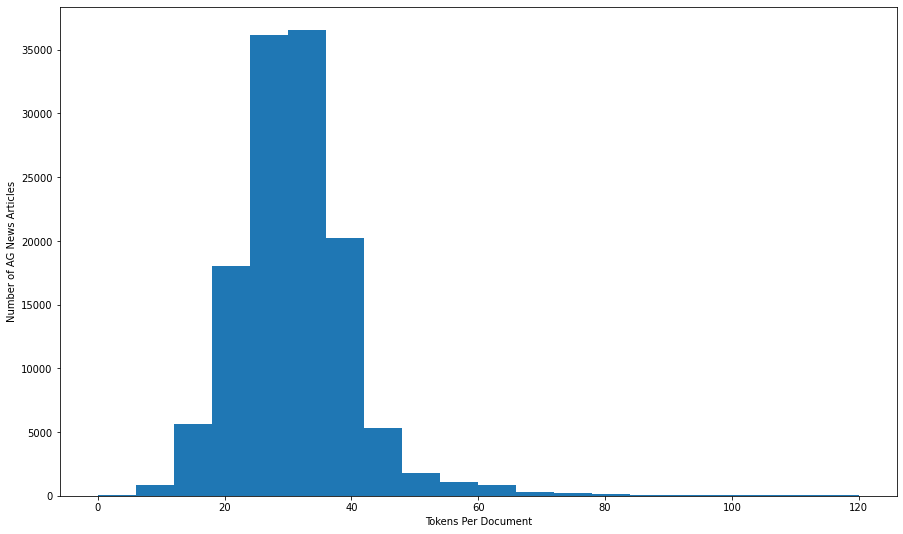

In [20]:
plt.figure(figsize=(15,9))
plt.hist(doc_sizes, bins=20,range = (0,120))
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles");

In [21]:
%%time
encoder_1000 = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=1000)
encoder_1000.adapt(dataset_all.map(lambda text, label: text))
vocab_1000 = np.array(encoder_1000.get_vocabulary());

Cause: could not parse the source code of <function <lambda> at 0x7fe6c8482e60>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fe6c8482e60>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fe6c8482e60>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 2min 1s, sys: 14.9 s, total: 2min 15s
Wall time: 2min 22s


In [22]:
vocab_1000[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U14')

In [23]:
example = "the dog ran after a red ball as it rolled by the hat on the ground."
encoder_1000(example)

<tf.Tensor: shape=(16,), dtype=int64, numpy=
array([  2,   1,   1,  29,   3, 232,   1,  14,  19,   1,  18,   2,   1,
         8,   2, 999])>

In [24]:
for word in example.split():
  print(f'"{word}" is {"*not* " if word not in vocab_1000  else ""}in the vocabulary.')

"the" is in the vocabulary.
"dog" is *not* in the vocabulary.
"ran" is *not* in the vocabulary.
"after" is in the vocabulary.
"a" is in the vocabulary.
"red" is in the vocabulary.
"ball" is *not* in the vocabulary.
"as" is in the vocabulary.
"it" is in the vocabulary.
"rolled" is *not* in the vocabulary.
"by" is in the vocabulary.
"the" is in the vocabulary.
"hat" is *not* in the vocabulary.
"on" is in the vocabulary.
"the" is in the vocabulary.
"ground." is *not* in the vocabulary.


In [25]:
%%time
doc1000_sizes = []
corpus1000 = []
count1000=0
useless = 0
# stop = 0
percents = []
for example, _ in dataset_all.as_numpy_iterator():
  # stop+=1
  # if stop > 5: break
  enc_example = encoder_1000(example)
  num_ones = tf.math.count_nonzero(enc_example==1).numpy()
  percent_ones = round(num_ones*100/len(enc_example))
  # print(f"{percent_ones}%")
  percents.append(percent_ones)

  s = set(list(enc_example.numpy()))
  if s == {1}: useless+=1

  doc1000_sizes.append(len(enc_example))
  corpus1000+=list(enc_example.numpy())

  count1000 += tf.math.count_nonzero(enc_example>1)

CPU times: user 10min 36s, sys: 12.2 s, total: 10min 48s
Wall time: 10min 17s


In [26]:
print(f"Each news article has between {min(doc1000_sizes)} and {max(doc1000_sizes)} tokens in it.")

Each news article has between 3 and 173 tokens in it.


### Preprocessing Data Create Input Pipeline

In [27]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# Example Approaches to Split Data Set
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:]','test[:1000]', 'test[1000:]'],
dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test[:]'],
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:114000]','train[114000:]', 'test[:]'],
                          as_supervised=True)
train_dataset, validation_dataset, test_dataset = dataset
# train_dataset, test_dataset = dataset['train'],dataset['test']

2022-02-20 06:43:54.377316: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
I0220 06:43:54.377593 140339823253376 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I0220 06:43:54.378811 140339823253376 dataset_info.py:361] Load dataset info from /root/tensorflow_datasets/ag_news_subset/1.0.0
I0220 06:43:54.380355 140339823253376 download_and_prepare.py:138] download_and_prepare for dataset ag_news_subset/1.0.0...
I0220 06:43:54.380605 140339823253376 dataset_builder.py:299] Reusing dataset ag_news_subset (/root/tensorflow_datasets/ag_news_subset/1.0.0)
name: "ag_news_subset"
description: "AG is a collection of more than 1 million news articles.\nNews articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.\nComeToMyHead is an academic news search engine which has been running since July, 2004.\nThe dataset is 

In [28]:
len(train_dataset),len(validation_dataset),len(test_dataset) 
# len(train_dataset),len(test_dataset) 

(114000, 6000, 7600)

### Review Distribution of Categorical Labels for the 114000 training data (news articles)

In [29]:
from collections import Counter
train_categories = [categories[label] for label in train_dataset.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Business', 28531), ('Sports', 28495), ('World', 28491), ('Sci/Tech', 28483)]

In [30]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('class: ', categories[label.numpy()])

text:  b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
class:  Sci/Tech


In [31]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('class: ', categories[label.numpy()])

text:  b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
class:  Sci/Tech


#### Preprocessing Shuffle Data for Training and Create Batches of `(text, label)` pairs:

In [32]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [33]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [34]:
for example, label in train_dataset.take(2): #take() Creates a Dataset with at most count elements from this dataset, so it returns the data elements (since it's been batched/bundled 64 instances per element)
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Violence erupted again yesterday in Port-au-Prince, one day after three policemen were killed in a clash with protesters demanding the return of ousted President Jean-Bertrand Aristide.'
 b'AP - Few people took notice when Sony Electronics Inc. opened a tiny storefront last year here at South Coast Plaza, a swanky mall south of Los Angeles. As it turns out, the small store would represent a big change in how Sony sells its televisions, DVD players and other gear.'
 b" NEW YORK (Reuters) - A record number of Americans planning  one last summer road trip this weekend will shell out the  highest Labor Day gasoline prices ever seen, and there's little  relief in sight, experts said on Tuesday."]

labels:  [0 3 2]
texts:  [b'The Fighting Irish opened the season Saturday night with a 20-17 loss at Brigham Young, a performance that doesn #39;t give much hope for a turnaround season.'
 b"US Airways' unions say the bankrupt airline is ''barking up the wrong tree quot; as it seeks to 

In [35]:
for example, label in train_dataset.take(2):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', [categories[n] for n in label.numpy()[:3]])
  print()

texts:  [b'Argentina #39;s David Nalbandian booked his place in the final of the Swiss Open for the third successive year on Saturday. The fourth-seed saw off Olympic gold medal winner Nicolas Massu of Chile 6-3 6-4 in the semi-final.'
 b"With the pro football season in full swing, it's time again for a superfluous digression into the corollaries between investing and sports. I can already hear some of you groaning, but cut me some slack."
 b'CANBERRA : Near record high imports increased Australia #39;s trade deficit by 10.5 percent in September, according to new data, which analysts say raises the prospects for an early rise in interest rates.']

labels:  ['Sports', 'Business', 'Business']

texts:  [b'EMERYVILLE, Calif. - Pixar Animation Studios said Thursday that third-quarter profit surged 70 percent as revenue continued to climb and said its newest film,  quot;The Incredibles, quot; is posting strong returns.'
 b'A private buyout firm that had said it was seeking to take control of

# **Experiment B - Testify Variants of RNN**

## Create the Text Encoder

1. tweek the vocabulary size of encoder
2. Vocabulary customization
3. output sequence length

In [36]:
#from the experiment A, we have identified the encoder with 3000 vocab size, unedited vocabulary, and arbitriy 128 output sequence yield the best result

# encoder 1 - 1000 vocabulary size, no edit of vocabulary, default output sequence length
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=3000, output_sequence_length=128)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [37]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

3000

In [38]:
vocab = np.array(encoder.get_vocabulary())
vocab[:100]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it',
       'has', 'new', 'an', 'from', 'his', 'us', 'will', 'was', 'reuters',
       'after', 'have', 'be', 'their', 'are', 'over', 'ap', 'he', 'but',
       'two', 'first', 'this', 'more', 'monday', 'wednesday', 'tuesday',
       'thursday', 'company', 'up', 'friday', 'inc', 'one', 'world',
       'yesterday', 'they', 'last', 'york', 'against', 'than', 'about',
       'who', 'not', 'were', 'into', 'year', 'been', 'out', 'president',
       'had', 'when', 'million', 'oil', 'corp', 'united', 'sunday',
       'would', 'which', 'week', 'years', 'today', 'three', 'people',
       'government', 'could', 'quot', 'group', 'no', 'time', 'game',
       'percent', 'saturday', 'software', 'night', 'or', 'iraq', 'prices',
       'next', 'security', 'minister', 'announced', 'some'], dtype='<U21')

Here are the 20 least frequent words.

In [39]:
vocab[-20:]

array(['barely', 'bar', 'xbox', 'teammate', 'silver', 'secondquarter',
       'referendum', 'quality', 'population', 'plenty', 'palm',
       'operators', 'memphis', 'materials', 'language', 'landing',
       'homeland', 'friendly', 'firsthalf', 'fed'], dtype='<U21')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):<br>
Default Batch Size = 32

In [40]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[   1,  898,    1,    1, 2427,   17,   45,   10,  457,  244, 1753,
        2005,   88,   14,  636,  702,    4,    1,    7,   17,   13,    1,
        1501, 1876,    1,   83,   16,    1,  356, 2781,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [   3,  837,    1,  327,   10,   67,   17,   19,   27, 1075,    4,
         198,  616,    5,    1,   49,   20,  860,   13,  705,

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [41]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'EMERYVILLE, Calif. - Pixar Animation Studios said Thursday that third-quarter profit surged 70 percent as revenue continued to climb and said its newest film,  quot;The Incredibles, quot; is posting strong returns.'
Round-trip:  [UNK] calif [UNK] [UNK] studios said thursday that thirdquarter profit surged 70 percent as revenue continued to [UNK] and said its [UNK] film quotthe [UNK] quot is [UNK] strong returns                                                                                                  

Original:  b'A private buyout firm that had said it was seeking to take control of MCI Inc. has sold its 5 percent stake in the long-distance giant for a \\$20 million pretax profit.&lt;br&gt;&lt;FONT face="verdana,MS Sans Serif,arial,helvetica" size="-2"\\ color="#666666"&gt;&lt;B&gt;-The Washington Post&lt;/B&gt;&lt;/FONT&gt;'
Round-trip:  a private [UNK] firm that had said it was seeking to take control of [UNK] inc has sold its 5 percent stake in the [UNK] giant fo

## Create the Model based on same encoder but variant model structure

In [42]:
num_classes = 4
model1 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())  #eahc input represents a word vector
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.SimpleRNN(64) #64 represents the number of cells within the layer, which represents the size of a sequenze of tokens the model oversees a time
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

## Compile Model 

In [43]:
model1.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [44]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 128)              0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 128, 64)           192000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                8256      
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 204,676
Trainable params: 204,676
Non-trainable params: 0
__________________________________________________

## Model Trainning

In [45]:
history1 = model1.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 109s 60ms/step - loss: 0.7078 - accuracy: 0.7087 - val_loss: 0.4330 - val_accuracy: 0.8507
Epoch 2/200
1782/1782 [==============================] - 108s 60ms/step - loss: 0.3886 - accuracy: 0.8670 - val_loss: 0.3824 - val_accuracy: 0.8690
Epoch 3/200
1782/1782 [==============================] - 115s 64ms/step - loss: 0.3582 - accuracy: 0.8785 - val_loss: 0.3717 - val_accuracy: 0.8715
Epoch 4/200
1782/1782 [==============================] - 114s 64ms/step - loss: 0.3457 - accuracy: 0.8832 - val_loss: 0.3711 - val_accuracy: 0.8692
Epoch 5/200
1782/1782 [==============================] - 113s 63ms/step - loss: 0.3326 - accuracy: 0.8876 - val_loss: 0.3660 - val_accuracy: 0.8720
Epoch 6/200
1782/1782 [==============================] - 113s 63ms/step - loss: 0.3147 - accuracy: 0.8934 - val_loss: 0.3488 - val_accuracy: 0.8790
Epoch 7/200
1782/1782 [==============================] - 112s 63ms/step - loss: 0.2955 - accuracy: 0.8986 - val_

In [46]:
test_loss, test_acc = model1.evaluate(test_dataset)

119/119 [==============================] - 2s 19ms/step - loss: 0.3617 - accuracy: 0.8762


In [47]:
history_dict = history1.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [48]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.708,0.709,0.433,0.851
1,0.389,0.867,0.382,0.869
2,0.358,0.878,0.372,0.872
3,0.346,0.883,0.371,0.869
4,0.333,0.888,0.366,0.872
5,0.315,0.893,0.349,0.879
6,0.296,0.899,0.336,0.882
7,0.280,0.903,0.338,0.883
8,0.266,0.908,0.343,0.879
9,0.254,0.912,0.351,0.877


In [49]:
losses = history1.history['loss']
accs = history1.history['accuracy']
val_losses = history1.history['val_loss']
val_accs = history1.history['val_accuracy']
epochs = len(losses)

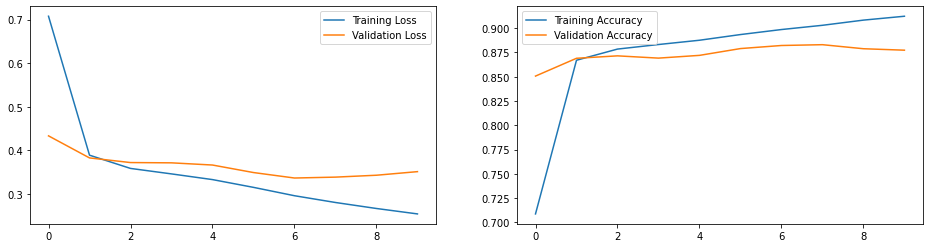

In [50]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [51]:
# track the test performance
test_accuracy = []
test_accuracy.append(test_acc)

In [52]:
## create model with endcoder 2 - bidirection Simple RNN

In [53]:
num_classes = 4
model2 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())  #eahc input represents a word vector
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64)) #64 represents the number of cells within the layer, which represents the size of a sequenze of tokens the model oversees a time
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

In [54]:
model2.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [55]:
history2 = model2.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 153s 85ms/step - loss: 0.7133 - accuracy: 0.6950 - val_loss: 0.3891 - val_accuracy: 0.8668
Epoch 2/200
1782/1782 [==============================] - 150s 84ms/step - loss: 0.3534 - accuracy: 0.8778 - val_loss: 0.3320 - val_accuracy: 0.8850
Epoch 3/200
1782/1782 [==============================] - 149s 84ms/step - loss: 0.3095 - accuracy: 0.8924 - val_loss: 0.3310 - val_accuracy: 0.8817
Epoch 4/200
1782/1782 [==============================] - 150s 84ms/step - loss: 0.2872 - accuracy: 0.8995 - val_loss: 0.3123 - val_accuracy: 0.8905
Epoch 5/200
1782/1782 [==============================] - 145s 81ms/step - loss: 0.2720 - accuracy: 0.9048 - val_loss: 0.3140 - val_accuracy: 0.8880
Epoch 6/200
1782/1782 [==============================] - 146s 82ms/step - loss: 0.2598 - accuracy: 0.9085 - val_loss: 0.3154 - val_accuracy: 0.8903


In [56]:
test_loss, test_acc = model2.evaluate(test_dataset)

119/119 [==============================] - 3s 21ms/step - loss: 0.3312 - accuracy: 0.8800


In [57]:
history_dict = history2.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [58]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.713,0.695,0.389,0.867
1,0.353,0.878,0.332,0.885
2,0.310,0.892,0.331,0.882
3,0.287,0.900,0.312,0.891
4,0.272,0.905,0.314,0.888
5,0.260,0.909,0.315,0.890


In [59]:
losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

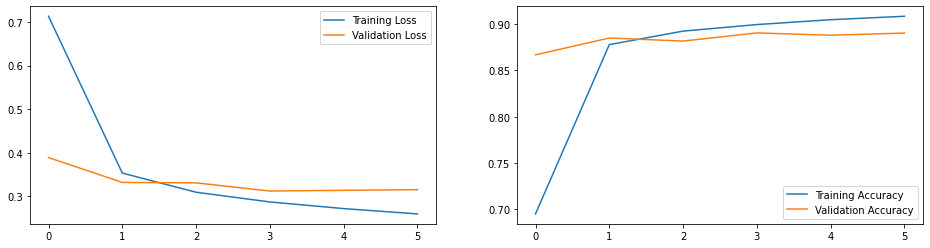

In [60]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [61]:
# track the test performance
test_accuracy.append(test_acc)

In [62]:
## create model with endcoder stacked Bidirectional Simple RNN

In [63]:
num_classes = 4
model3 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [64]:
model3.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [65]:
history3 = model3.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 284s 157ms/step - loss: 0.7905 - accuracy: 0.6693 - val_loss: 0.4048 - val_accuracy: 0.8655
Epoch 2/200
1782/1782 [==============================] - 282s 158ms/step - loss: 0.4098 - accuracy: 0.8688 - val_loss: 0.3536 - val_accuracy: 0.8805
Epoch 3/200
1782/1782 [==============================] - 279s 157ms/step - loss: 0.3562 - accuracy: 0.8855 - val_loss: 0.3366 - val_accuracy: 0.8887
Epoch 4/200
1782/1782 [==============================] - 283s 159ms/step - loss: 0.3272 - accuracy: 0.8953 - val_loss: 0.3283 - val_accuracy: 0.8890
Epoch 5/200
1782/1782 [==============================] - 285s 160ms/step - loss: 0.3071 - accuracy: 0.9016 - val_loss: 0.3318 - val_accuracy: 0.8878
Epoch 6/200
1782/1782 [==============================] - 285s 160ms/step - loss: 0.2896 - accuracy: 0.9071 - val_loss: 0.3289 - val_accuracy: 0.8852


In [66]:
test_loss, test_acc = model3.evaluate(test_dataset)

119/119 [==============================] - 5s 42ms/step - loss: 0.3388 - accuracy: 0.8838


In [67]:
history_dict = history3.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [68]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.791,0.669,0.405,0.865
1,0.410,0.869,0.354,0.881
2,0.356,0.886,0.337,0.889
3,0.327,0.895,0.328,0.889
4,0.307,0.902,0.332,0.888
5,0.290,0.907,0.329,0.885


In [69]:
losses = history3.history['loss']
accs = history3.history['accuracy']
val_losses = history3.history['val_loss']
val_accs = history3.history['val_accuracy']
epochs = len(losses)

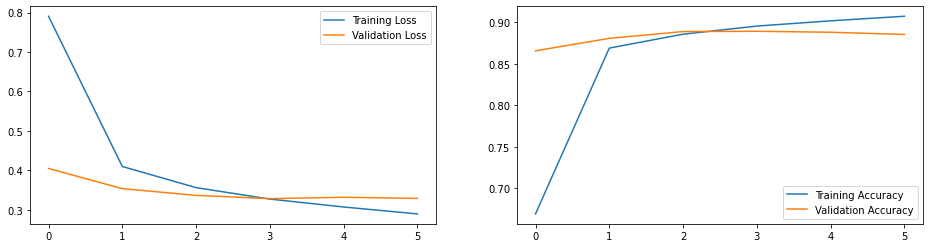

In [70]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [71]:
# track the test performance
test_accuracy.append(test_acc)

In [72]:
## create model with stacked one direction simpleRNN

In [73]:
num_classes = 4
model4 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.SimpleRNN(64,  return_sequences=True)
                              ,tf.keras.layers.SimpleRNN(32)
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [74]:
model4.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [75]:
history4 = model4.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 170s 94ms/step - loss: 0.7414 - accuracy: 0.7076 - val_loss: 0.4167 - val_accuracy: 0.8563
Epoch 2/200
1782/1782 [==============================] - 167s 94ms/step - loss: 0.4153 - accuracy: 0.8643 - val_loss: 0.3716 - val_accuracy: 0.8725
Epoch 3/200
1782/1782 [==============================] - 167s 94ms/step - loss: 0.3670 - accuracy: 0.8805 - val_loss: 0.3601 - val_accuracy: 0.8720
Epoch 4/200
1782/1782 [==============================] - 168s 94ms/step - loss: 0.3436 - accuracy: 0.8880 - val_loss: 0.3485 - val_accuracy: 0.8780
Epoch 5/200
1782/1782 [==============================] - 167s 94ms/step - loss: 0.3270 - accuracy: 0.8935 - val_loss: 0.3590 - val_accuracy: 0.8727
Epoch 6/200
1782/1782 [==============================] - 162s 91ms/step - loss: 0.3129 - accuracy: 0.8989 - val_loss: 0.3532 - val_accuracy: 0.8773


In [76]:
test_loss, test_acc = model4.evaluate(test_dataset)

119/119 [==============================] - 3s 24ms/step - loss: 0.3640 - accuracy: 0.8751


In [77]:
history_dict = history4.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [78]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.741,0.708,0.417,0.856
1,0.415,0.864,0.372,0.873
2,0.367,0.881,0.360,0.872
3,0.344,0.888,0.348,0.878
4,0.327,0.893,0.359,0.873
5,0.313,0.899,0.353,0.877


In [79]:
losses = history4.history['loss']
accs = history4.history['accuracy']
val_losses = history4.history['val_loss']
val_accs = history4.history['val_accuracy']
epochs = len(losses)

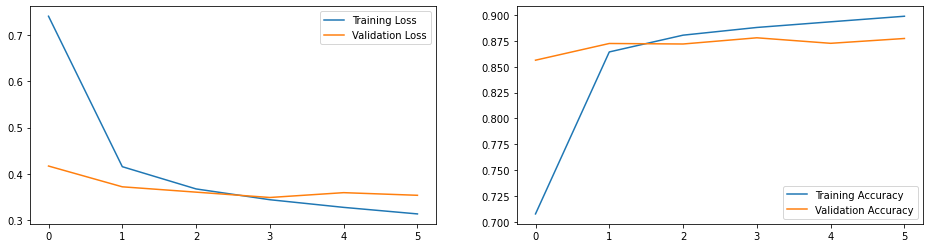

In [80]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [81]:
# track the test performance
test_accuracy.append(test_acc)

In [82]:
## create model with endcoder 5

# If your training/validation loss are about equal then your model is underfitting. 
# Increase the size of your model (either number of layers or the raw number of neurons per layer)

In [83]:
#increase # of neurons as well as depth of model 

num_classes = 4
model5 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(128,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64, return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

In [84]:
model5.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [85]:
history5 = model5.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

Epoch 1/200
1782/1782 [==============================] - 522s 289ms/step - loss: 0.6844 - accuracy: 0.7326 - val_loss: 0.3784 - val_accuracy: 0.8728
Epoch 2/200
1782/1782 [==============================] - 509s 286ms/step - loss: 0.3672 - accuracy: 0.8810 - val_loss: 0.3308 - val_accuracy: 0.8870
Epoch 3/200
1782/1782 [==============================] - 512s 287ms/step - loss: 0.3246 - accuracy: 0.8936 - val_loss: 0.3277 - val_accuracy: 0.8860
Epoch 4/200
1782/1782 [==============================] - 512s 287ms/step - loss: 0.2993 - accuracy: 0.9014 - val_loss: 0.3261 - val_accuracy: 0.8888
Epoch 5/200
1782/1782 [==============================] - 513s 288ms/step - loss: 0.2749 - accuracy: 0.9091 - val_loss: 0.3240 - val_accuracy: 0.8880
Epoch 6/200
1782/1782 [==============================] - 512s 287ms/step - loss: 0.2493 - accuracy: 0.9169 - val_loss: 0.3367 - val_accuracy: 0.8878


In [86]:
test_loss, test_acc = model5.evaluate(test_dataset)

119/119 [==============================] - 10s 80ms/step - loss: 0.3531 - accuracy: 0.8818


In [87]:
history_dict = history5.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [88]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.684,0.733,0.378,0.873
1,0.367,0.881,0.331,0.887
2,0.325,0.894,0.328,0.886
3,0.299,0.901,0.326,0.889
4,0.275,0.909,0.324,0.888
5,0.249,0.917,0.337,0.888


In [89]:
losses = history5.history['loss']
accs = history5.history['accuracy']
val_losses = history5.history['val_loss']
val_accs = history5.history['val_accuracy']
epochs = len(losses)

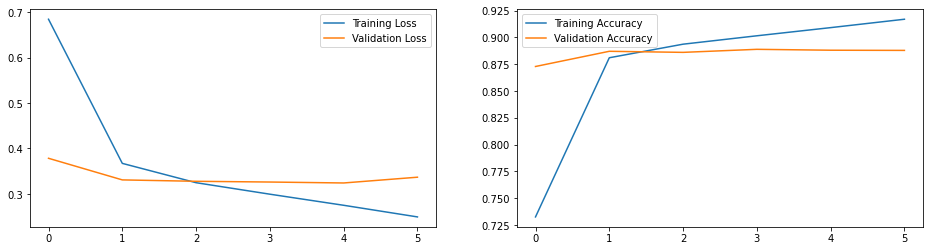

In [90]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [91]:
#the plot above suggest strong overfitting for the model with three layers of Simple RNN

In [92]:
# track the test performance
test_accuracy.append(test_acc)

##collect the model results

In [93]:
test_accuracy

[0.8761842250823975,
 0.8799999952316284,
 0.8838157653808594,
 0.8751316070556641,
 0.8818420767784119]

In [94]:
model_name =['model1','model2','model3','model4','model5']
model_descr =['1 SimpleRNN (64)',
              '1 Bidirectional Simple RNN (64)', 
              '2 Bidirectional Simple RNN (64, 32)', 
              '2 Simple RNN (64, 32)',
              '3 Bidirectional Simple RNN (128, 64, 32)'
              ]

In [95]:
perf_dict = { 'model' : model_name,
              'description': model_descr,
              'test_accuracy': test_accuracy
}

df_perf = pd.DataFrame(perf_dict)
print(df_perf)

    model                               description  test_accuracy
0  model1                          1 SimpleRNN (64)       0.876184
1  model2           1 Bidirectional Simple RNN (64)       0.880000
2  model3       2 Bidirectional Simple RNN (64, 32)       0.883816
3  model4                     2 Simple RNN (64, 32)       0.875132
4  model5  3 Bidirectional Simple RNN (128, 64, 32)       0.881842


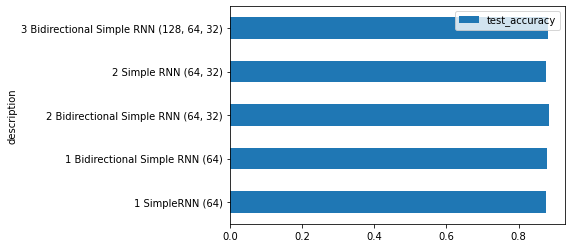

In [96]:
df_perf.plot.barh(x='description', y='test_accuracy')

In [97]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [98]:
%%shell
jupyter nbconvert --to html /content/gdrive/MyDrive/458_AI/Assignment3/Liu_Assignment3_Part1.ipynb

[NbConvertApp] Converting notebook /content/gdrive/MyDrive/458_AI/Assignment3/Liu_Assignment3_Part1.ipynb to html
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/jupyter_core/application.py", line 267, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/nbconvert/nbconvertapp.py", line 338, in start
    self.convert_notebooks()
  File "/usr/local/lib/python2.7/dist-packages/nbconvert/nbconvertapp.py", line 508, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/usr/local/lib/python2.7/dist-packages/nbconvert/nbconvertapp.py", line 479, in convert_single_notebook
    output, resources = self.export_single_notebook(notebook_filename, 

CalledProcessError: ignored